# Causal inference for decision-making in growth hacking and upselling in Python

> "In this article we discuss differences between experimental and observational data and pitfalls in using the latter for data-driven decision-making."
- toc: true
- branch: master
- badges: true
- comments: true
- categories: [python, dowhy, causal inference]

## Introduction

Wow, growth hacking *and* upselling all in the same article? Also Python.

Okay, let's start at the beginning. Imagine the following scenario: You're responsible for increasing the amount of money users spend on your e-commerce platform.

You and your team come up with different measures you could implement to achieve your goal. Two of these measures could be:

- Provide a discount on your best-selling items,
- Implement a rewards program that incentivices repeat purchases.

Both of these measures are fairly complex with each incurring a certain, probably known, amount of cost and an unknown effect on your customers' spending behaviour.

To decide which of these two possible measures is worth both the effort and incurred cost you need to estimate their effect on customer spend.

A natural way of estimating this effect is computing the following:

$\textrm{avg}(\textrm{spend} | \textrm{treatment} = 1) - \textrm{avg}(\textrm{spend} | \textrm{treatment} = 0) = \textrm{ATE}$.

Essentially you would compute the average spend of users who received the treatment (received a discount or signed up for rewards) and subtract from that the average spend of users who didn't receive the treatment.

Without discussing the details of the underlying potential outcomes framework, the above expression is called the average treatment effect (ATE).

## Let's estimate the average treatment effect and make a decision!

So now we'll just analyze our e-commerce data of treated and untreated customers and compute the average treatment effect (ATE) for each proposed measure, right? Right?

Before you rush ahead with your ATE computations - now is a good time to take a step back and contemplate how your data was generated in the first place(data-generating process).

## References and further material ...

Before we continue: My example here is based on a tutorial by the authors of the excellent DoWhy library. You can find the original tutorial here:

https://github.com/microsoft/dowhy/blob/master/docs/source/example_notebooks/dowhy_example_effect_of_memberrewards_program.ipynb

And more on DoWhy here: https://microsoft.github.io/dowhy/

## Install and load libraries

In [1]:
!pip install dowhy --quiet

In [2]:
import random

import pandas as pd
import numpy as np

np.random.seed(42)
random.seed(42)

## Randomized controlled trial / experimental data

So where were we ... ah right! Where does our e-commerece data come from?

Since we don't actually run an e-commerce operation here we will have to simulate our data (remember: these ideas are based on the above DoWhy tutorial).

Imagine we observe the monthly spend of each of our 10,000 users over the course of a year. Each user will spend with a certain distribution (here, a Poisson distribution) and there are both high and low spenders with different mean spends.

Over the course of the year, each user can sign up to our rewards program in any month and once they have signed up their spend goes up by 50% relative to what they would've spent without signing up.

So far so mundane: Different customers show different spending behaviour and signing up to our rewards program increases their spend.

Now the big question is: How are treatment assignment (rewards program signup) and outcome (spending behaviour) related? 

If treatment and outcome, interpreted as random variables, are independent of one another then according to the potential outcome framework we can compute the ATE as easily as shown above:

$\textrm{ATE} = \textrm{avg}(\textrm{spend} | \textrm{treatment} = 1) - \textrm{avg}(\textrm{spend} | \textrm{treatment} = 0)$

When are treatment and outcome independent? The gold standard for achieving their independence in a data set is the randomized controlled trial (RCT).

In our scenario what an RCT would look like is randomly signing up our users to our rewards program - indepndent of their spending behaviour or any other characteristic.

So we would go through our list of 10,000 users and flip a coin for each of them, sign them up to our program in a random month of the year based on our coin, and send them on their merry way to continue buying stuff in our online shop.

Let's put all of this into a bit of code that simulates the spending behaviour of our users according to our thought experiment:

In [3]:
# Creating some simulated data for our example
num_users = 10000
num_months = 12

df = pd.DataFrame({
    'user_id': np.repeat(np.arange(num_users), num_months),
    'month': np.tile(np.arange(1, num_months+1), num_users), # months are from 1 to 12
    'high_spender': np.repeat(np.random.randint(0, 2, size=num_users), num_months),
})

df['spend'] = None
df.loc[df['high_spender'] == 0, 'spend'] = np.random.poisson(250, df.loc[df['high_spender'] == 0].shape[0])
df.loc[df['high_spender'] == 1, 'spend'] = np.random.poisson(750, df.loc[df['high_spender'] == 1].shape[0])
df["spend"] = df["spend"] - df["month"] * 10

signup_months = np.random.choice(
    np.arange(1, num_months),
    num_users
) * np.random.randint(0, 2, size=num_users)  # signup_months == 0 means customer did not sign up

df['signup_month'] = np.repeat(signup_months, num_months)

# A customer is in the treatment group if and only if they signed up
df["treatment"] = df["signup_month"] > 0

# Simulating a simple treatment effect of 50%
after_signup = (df["signup_month"] < df["month"]) & (df["treatment"])
df.loc[after_signup, "spend"] = df[after_signup]["spend"] * 1.5

Let's look at user `0` and their treatment assignment as well as spend (since we're sampling random variables here you'll see something different from me):

In [4]:
df.loc[df['user_id'] == 0]

,user_id,month,high_spender,spend,signup_month,treatment
0,0,1,0,235,0,False
1,0,2,0,249,0,False
2,0,3,0,240,0,False
3,0,4,0,224,0,False
4,0,5,0,184,0,False
5,0,6,0,172,0,False
6,0,7,0,182,0,False
7,0,8,0,155,0,False
8,0,9,0,120,0,False
9,0,10,0,153,0,False


## Average treatment effect on post-signup spend for experimental data

The effect we're interested in is the impact of rewards signup on spending behaviour - i.e. the effect on post-signup spend.

Since customers can sign up any month of the year, we'll choose one month at random and compute the effect with respect to that one month.

So let's create a new table from our time series where we collect post-signup spend for those customers that signed up in `month = 6` alongside the spend of customers who never signed up.

In [5]:
month = 6

post_signup_spend = (
    df[df.signup_month.isin([0, month])]
    .groupby(["user_id", "signup_month", "treatment"])
    .apply(
        lambda x: pd.Series(
            {
                "post_spend": x.loc[x.month > month, "spend"].mean(),
            }
        )
    )
    .reset_index()
)
print(post_signup_spend)

      user_id  signup_month  treatment  post_spend
0           0             0      False  152.833333
1           3             0      False  162.166667
2           4             0      False  146.333333
3           6             0      False  153.666667
4           7             6       True  240.750000
...       ...           ...        ...         ...
5451     9990             0      False  629.833333
5452     9993             0      False  674.500000
5453     9994             0      False  681.000000
5454     9995             0      False  641.333333
5455     9998             0      False  658.833333

[5456 rows x 4 columns]


To get the average treatment effect (ATE) of our rewards signup treatment we now compute the average post-signup spend of the customers who signed up and subtract from that the average spend of users who didn't sign up:

In [6]:
post_spend = post_signup_spend\
  .groupby('treatment')\
  .agg({'post_spend': 'mean'})

post_spend

,post_spend
treatment,
False,403.512239
True,610.140371


So the ATE of rewards signup on post-signup spend is:

In [7]:
post_spend.loc[True, 'post_spend'] - post_spend.loc[False, 'post_spend']

206.62813242372852

Since we simulated the treatment effect ourselves (50% post-signup spend increase) let's see if we can recover this effect from our data:

In [8]:
post_spend.loc[True, 'post_spend'] / post_spend.loc[False, 'post_spend']

1.5120740154875112

The post-signup spend for treated customers is roughly 50% greater than the spend for untreated customers - exactly the treatment effect we simulated!

Remember, however, that we are dealing with clean experimental data from a randomized controlled trial (RCT) here! The potential outcome framework tells us that for data from an RCT the simple ATE formula we used here yields the correct treatment effect due to independence of treatment assignment and outcome.

So the fact that we recovered the actual (simulated) treatment effect is nice to see but not surprising.

## The issue with randomized controlled trials and observational data

Our above thought experiment where we randomly assigned our customers to our rewards program isn't very realistic.

Randomly signing up paying customers to rewards programs without their consent may upset some and may not even be permissible. The same issue with randomized treatment assignment pops up everywhere - clean randomized controlled trials are oftentimes too expensive, infeasible to implement, unethical, or not permitted.

But since we still need to experiment with our shop to drive spending behaviour we'll still go ahead and implement our rewards program. Only that this time we'll place a regular signup page in our shop where our customers can decide for themselves if they want to sign up or not.

Activating our signup page and simply observing how users and their spend behaves gives us **observational data**.

We usually call "observational data" just "data" without giving much thought to where they came from. I mean we've all dealt with lots of different kinds of data (marketing data, R&D measurements, HR data, etc.) and all these data were simply "observed" and didn't come out of a carefully set up experiment.

Simulating our observational data we've got the same 10,000 customers over a span of a year. We still have the same high and low spenders.

Only that now our high spenders are far more likely to sign up to our rewards program than our low spenders. My reasoning for this is that customers who spend more are also more likely to show greater brand loyalty towards us and our rewards program. Further, they visit our shop more frequently hence are more likely to notice our new rewards program and the signup page. We could also add this behaviour as random variables to our simulation below but just take a shortcut and give low spenders a 5% chance of signing up and high spenders a 95% chance.

In [9]:
num_users = 10000
num_months = 12

df = pd.DataFrame({
    'user_id': np.repeat(np.arange(num_users), num_months),
    'month': np.tile(np.arange(1, num_months+1), num_users), # months are from 1 to 12
    'high_spender': np.repeat(np.random.randint(0, 2, size=num_users), num_months),
})

df['spend'] = None
df.loc[df['high_spender'] == 0, 'spend'] = np.random.poisson(250, df.loc[df['high_spender'] == 0].shape[0])
df.loc[df['high_spender'] == 1, 'spend'] = np.random.poisson(750, df.loc[df['high_spender'] == 1].shape[0])

signup_months = df[['user_id', 'high_spender']].drop_duplicates().copy()
signup_months['signup_month'] = None

signup_months.loc[signup_months['high_spender'] == 0, 'signup_month'] = np.random.choice(
    np.arange(1, num_months),
    (signup_months['high_spender'] == 0).sum()
) * np.random.binomial(1, .05, size=(signup_months['high_spender'] == 0).sum())

signup_months.loc[signup_months['high_spender'] == 1, 'signup_month'] = np.random.choice(
    np.arange(1, num_months),
    (signup_months['high_spender'] == 1).sum()
) * np.random.binomial(1, .95, size=(signup_months['high_spender'] == 1).sum())

df = df.merge(signup_months)

df["treatment"] = df["signup_month"] > 0

after_signup = (df["signup_month"] < df["month"]) & (df["treatment"])
df.loc[after_signup, "spend"] = df[after_signup]["spend"] * 1.5

df

,user_id,month,high_spender,spend,signup_month,treatment
0,0,1,1,778,11,True
1,0,2,1,726,11,True
2,0,3,1,704,11,True
3,0,4,1,723,11,True
4,0,5,1,718,11,True
...,...,...,...,...,...,...
119995,9999,8,1,745,0,False
119996,9999,9,1,777,0,False
119997,9999,10,1,776,0,False
119998,9999,11,1,744,0,False


Now imagine you weren't aware of causality, confounders, high / low spenders, and all that. You simply published your rewards signup page and observed your customers' spending behaviour over a span of a year. Chances are you'll compute the average treatment effect the exact same way we did above for our randomized controlled trial:

In [10]:
month = 6

post_signup_spend = (
    df[df.signup_month.isin([0, month])]
    .groupby(["user_id", "signup_month", "treatment"])
    .apply(
        lambda x: pd.Series(
            {
                "post_spend": x.loc[x.month > month, "spend"].mean(),
                "pre_spend": x.loc[x.month < month, "spend"].mean(),
            }
        )
    )
    .reset_index()
)
print(post_signup_spend)

      user_id  signup_month  treatment  post_spend  pre_spend
0           1             0      False  251.666667      239.0
1           3             0      False  246.166667      252.8
2           4             0      False  740.833333      737.2
3           6             0      False  254.333333      247.0
4           7             0      False  249.166667      253.2
...       ...           ...        ...         ...        ...
5499     9992             0      False  246.000000      240.6
5500     9995             0      False  254.833333      256.4
5501     9996             0      False  248.833333      239.8
5502     9997             0      False  249.500000      247.8
5503     9999             0      False  761.666667      752.6

[5504 rows x 5 columns]


In [11]:
post_spend = post_signup_spend\
  .groupby('treatment')\
  .agg({'post_spend': 'mean'})

post_spend

,post_spend
treatment,
False,275.891760
True,1075.543699


In [12]:
post_spend.loc[True, 'post_spend'] - post_spend.loc[False, 'post_spend']

799.6519394104552

In [13]:
post_spend.loc[True, 'post_spend'] / post_spend.loc[False, 'post_spend']

3.8984263250854134

Performing the exact same computation as above, now we're estimating an average treatment effect of almost 400% instead of the actual 50%!

So what went wrong here?

Observational data got us!

Realize that in our observational data the outcome (spend) is not indepndent of treatment assignmnet (rewards program signup): High spenders are far more likely to sign up hence are overrepresented in our treatment group while low spenders are overrepresented in our control group (users that didn't sign up).

So when we compute the above difference or ratio we don't just see the average treatment effect of rewards signup we also see the inherent difference in spending between high and low spenders.

So if we ignore how our observational data are generated we'll overestimate the effect our rewards program has and likely make decisions that seem to be supported by data but in reality aren't.

Also notice that we often make this same mistake when training machine learning algorithms on observational data. Chances are someone will ask you to train a regression model to predict the effectiveness of the rewards program and your model will end up with the same inflated estimate as above.

So how do we fix this? And how can we estimate the true treatment effect from our observational data?

Generally, we know from experience in e-commerece that people who tend to spend more are more likely to sign up to our rewards program. So we could segment our users into spend buckets and compute the treatment effect within each bucket to try and breeak this confounding link in our observational data.

Notice that in practice we won't have a `high spender` flag for our customers so we'll have to go by our customers' observed spending behaviour.

The causal inference framework offers an established approach here: Relying on our domain knowledge, we define a causal model that describes how we believe our observational data were generated.

Let's draw this as a graph with nodes and edges:

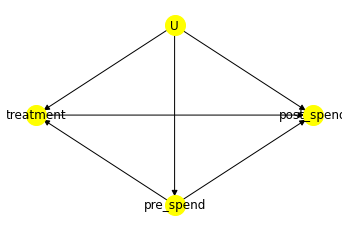

In [14]:
import os, sys
sys.path.append(os.path.abspath("../../../"))
import dowhy

causal_graph = """digraph {
treatment[label="Program Signup in month i"];
pre_spend;
post_spend;
U[label="Unobserved Confounders"]; 
pre_spend -> treatment;
pre_spend -> post_spend;
treatment->post_spend;
U->treatment; U->pre_spend; U->post_spend;
}"""

model = dowhy.CausalModel(
    data=post_signup_spend,
    graph=causal_graph.replace("\n", " "),
    treatment="treatment",
    outcome="post_spend"
)
model.view_model()

Our causal model states what we described above: Pre-signup spend influences both rewards signup (treatment assignment) and post-signup spend. This is the story about our high and low spenders.

Treatment (rewards signup) influences post-signup spending behaviour - this is the effect we're actually interested in.

We also added a node `U` to signify possible other confounding factors that may exist in reality but weren't observed as part of our data.

## Identification / identifying the causal effect

We will now apply do-calculus to our causal model from above to figure out ways to cleanly estimate the treatment effect we're after:

In [15]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                         
────────────(Expectation(post_spend|pre_spend))
d[treatment]                                   
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→post_spend then P(post_spend|treatment,pre_spend,U) = P(post_spend|treatment,pre_spend)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



Very broadly and sloppily stated there a three ways to segment (or slice and dice) our observational data to get to subsets of our data within which we can cleanly compute the average treatment effect:

- Backdoor adjustment,
- Frontdoor adjustment, and
- Instrumental variables.

The above printout tells us that based on both the causal model we constructed and our observational data there is a backdoor-adjusted estimator for our desired treatment effect.

This backdoor adjustment actually follows closely what we already said above: We'll compute the post-spend given pre-spend (segment our customers based on their spending behaviour).

## Estimating the treatment effect

There are various ways to perform the backdoor adjustment that DoWhy identified for us above. One of them is called propensity score matching:

In [16]:
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor1.propensity_score_matching",
    target_units="ate"
)

print(estimate)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: post_spend~treatment+pre_spend
Target units: ate

## Estimate
Mean value: 159.15597747093042



DoWhy provides us with an estimated ATE for our observational data that is pretty close to the ATE we computed for our experimental data from our randomized controlled trial.

Even if the ATE estimate DoWhy provides doesn't match exactly our experimental ATE we're now in a much better position to take a decision regarding our rewards program based on our observational data.

So next time we want to base decisions on observational data it'll be worthwhile defining a causal model of the underlying data-generating process and using a library such as DoWhy that helps us identify and apply adjustment strategies.